# Setup

In [5]:
import torch
import numpy as np
import argparse
import importlib

In [6]:
# Arguments ===================================
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--dataset', type=str, default='Cora', choices=[
    'Cora', 'Cora-ML', 'Citeseer', 'Pubmed', 'Polblogs', 'ACM', 'BlogCatalog', 'Flickr', 'UAI'
])
parser.add_argument('--g0_method', type=str, default='random', choices=[
  'random', # randomly distribution of g0
  'bias', # a random class has a 3x higher likelihood of being in g0
  'large_cluster', # a random node and [g0_size] of its neighbors are in g0
  'many_clusters', # 10 random nodes and [g0_size] of their neighbors are in g0
  ])
parser.add_argument('--g0_size', type=float, default=0.2)
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--T_s', type=int, default=-1)
parser.add_argument('--T_u', type=int, default=0)

parser.add_argument('--attack_method', type=str, default='sll_no_g', choices=[
  'SLL_G', # Selective Learnability Lock
  'SLL', # Disable gradient guidance
  'REF', # Noise protection
  'CER', # Heuristic protection
  ])
parser.add_argument('--budget_pct', type=float, default=0.25)
parser.add_argument('--SLL_sample_size', type=int, default=2000)
parser.add_argument('--SLL_num_samples', type=int, default=100)
parser.add_argument('--attack_epochs', type=int, default=30)
parser.add_argument('--save_results', type=str, default='Y', choices=['N', 'Y'])
parser.add_argument('--save_graph', type=str, default='N', choices=['N', 'Y'])

args = parser.parse_args("")
device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

In [7]:
from deeprobust.graph.data import Dataset
from deeprobust.graph.utils import preprocess

clean_dataset = Dataset(root='./tmp/', name=args.dataset, seed=args.seed)
adj, feat, labels = clean_dataset.adj, clean_dataset.features, clean_dataset.labels
adj, feat, labels = preprocess(adj, feat, labels, preprocess_adj=False, device=device) # conver to tensor
idx_train, idx_val, idx_test = clean_dataset.idx_train, clean_dataset.idx_val, clean_dataset.idx_test
# adj = torch.tensor(clean_dataset.adj.toarray(), dtype=torch.float).to(device)
# feat = torch.tensor(clean_dataset.features.toarray(), dtype=torch.float).to(device)
# label = torch.tensor(clean_dataset.labels, dtype=torch.long).to(device)

train_mask = torch.zeros([adj.shape[0]], dtype=torch.bool)  
train_mask[idx_train] = 1
test_mask = torch.zeros([adj.shape[0]], dtype=torch.bool)  
test_mask[idx_test] = 1

Loading cora dataset...
Selecting 1 largest connected components


In [8]:
import utils

T_s = T_u = torch.tensor([0])

if args.T_s == -1: T_s = labels
else:
    T_s = utils.binary(feat[:,args.T_s].clone())
    feat[:,args.T_s] = 0

if args.T_u == -1: T_u = labels
else:
    T_u = utils.binary(feat[:,args.T_u].clone())
    feat[:,args.T_u] = 0

In [9]:
# Designate g0 ===================================
g0_size = int(args.g0_size * adj.shape[0])

def get_clusters(num_roots: int, max_hops: int, target_size: int) -> torch.Tensor:
  root_nodes = torch.rand(adj.shape[0]).topk(num_roots).indices

  for hop in range(max_hops):
    newNodes = adj[root_nodes].nonzero().t()[1]
    root_nodes = torch.cat((root_nodes, newNodes))
    root_nodes = torch.unique(root_nodes)
    if root_nodes.shape[0] >= target_size:
      break

  g0 = torch.zeros(adj.shape[0])
  g0[root_nodes[:target_size]] = 1
  g0 = g0.bool()
  return g0

g0 = torch.tensor([0])
if args.g0_method == 'many_clusters': # 10 nodes and their neighbors
  g0 = get_clusters(10, 10, g0_size)
elif args.g0_method == 'large_cluster': # 1 node and its neighbors
  g0 = get_clusters(1, 10, g0_size)
elif args.g0_method == 'random': # g0 is random/bias
  g0_probs = torch.ones(adj.shape[0])
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()
elif args.g0_method == 'bias': # g0 is skewed toward a class by factor of 3
  bias = torch.randint(0, int(labels.max()) + 1, [1]).item()
  print(f'G0 class bias: {bias}')
  g0_probs = torch.ones(adj.shape[0])
  g0_probs[labels == bias] = 3
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()

print(f'G0 size: {g0.sum().item()}')
print(f'G0 pct: {g0.sum().item() / adj.shape[0]:.2%}')

g0 = g0.cpu()
gX = ~g0

G0 size: 519
G0 pct: 20.89%


# Do Attack

In [22]:
import torch

def scale(M: torch.Tensor, epsilon: int, patience=10) -> torch.Tensor:
    for i in range(patience): # Maximum attempts
        if abs(epsilon / M.abs().sum() - 1) < 0.1: return M # Stop with early convergence
        M = (M * (epsilon / M.abs().sum())).clamp(0, 1)

    return M

def discretize(M: torch.Tensor, epsilon: int) -> torch.Tensor:
    return torch.bernoulli(scale(M, epsilon).abs())

def truncate(M: torch.Tensor, A: torch.Tensor) -> torch.Tensor:
    """
    Truncates values in M such that only:
    1. positive values exist in M corresponding to non-existing edges
    2. negative values exist in M corresponding to alread existing edges
    """
    assert M.shape == A.shape
    negative_vals = (M * A).clamp(max=0)
    positive_vals = (M * (1-A)).clamp(min=0)
    return positive_vals + negative_vals

def xor(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    return (A + B) - torch.mul(A * B, 2)

In [21]:
# Perform attack ==========================

from deeprobust.graph.defense import GCN
import utils
import torch.nn.functional as F
from tqdm import tqdm

num_perturbations = (adj.shape[0]) * args.budget_pct

print(f'Attacking with method: {args.attack_method}')

if args.attack_method == 'heuristic':
  locked_adj = adj.clone()
  locked_adj[:, g0] = 0
  locked_adj[g0, :] = 0
elif args.attack_method == 'noise':
  noise = torch.zeros_like(adj)
  noise[g0, :] = 1
  noise[:, gX] = 0
  noise *= 2 * num_perturbations / noise.sum()
  noise = torch.bernoulli(noise.clamp(0, 1))
  noise = utils.make_symmetric(noise)
  locked_adj = utils.get_modified_adj(adj, noise)
elif args.attack_method == 'sll_no_g':
  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float().to(device)

  # Create surrogate model to mimic downstream
  θ_s = GCN(nfeat=feat.shape[1], nclass=T_s.max().item()+1, nhid=32, device=device).to(device)
  θ_u = GCN(nfeat=feat.shape[1], nclass=T_u.max().item()+1, nhid=32, device=device).to(device)

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL (no gradient guidance)")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).requires_grad_(True).float().to(device)

    # Get grad of modified adj w.r.t attack loss
    loss = 0
    sens_pred = θ_s(feat, modified_adj)
    loss += F.cross_entropy(sens_pred[g0], T_s[g0]) \
      - F.cross_entropy(sens_pred[gX], T_s[gX])
    
    utility_pred = θ_u(feat, modified_adj)
    loss -= F.cross_entropy(utility_pred, T_u)
    
    adj_grad = torch.autograd.grad(loss, modified_adj)[0].cpu()

    # Update perturbations
    lr = (1000 / (epoch + 1))
    # pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad.to(device))
    perturbations = utils.projection(perturbations, num_perturbations)

    # Train the surrogate
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)
    diff = adj - modified_adj

    θ_s.fit(feat, modified_adj, T_s, idx_train, idx_val, train_iters=1)
    θ_u.fit(feat, modified_adj, T_u, idx_train, idx_val, train_iters=1)

    t.set_postfix({
      "loss": loss.item(),
      "edges modified": diff.abs().sum().item() / 2
      })
    
elif args.attack_method == 'sll':
  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float()

  # Initialize sampling matrix
  import sampling_matrix
  samplingMatrix = sampling_matrix.SamplingMatrix(
    g0=g0, gX=gX, adj=adj, sample_size=args.SLL_sample_size)
  count = torch.zeros_like(adj).float()

  # Create surrogate model to mimic downstream
  θ_s = GCN(nfeat=feat.shape[1], nclass=T_s.max().item()+1, nhid=32, device=device).to(device)
  θ_u = GCN(nfeat=feat.shape[1], nclass=T_u.max().item()+1, nhid=32, device=device).to(device)

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).float().to(device)

    loss_cum = 0
    for sample_epoch in range(args.SLL_num_samples): 
      # Get sample indices
      idx = samplingMatrix.get_sample()

      # Map sample to adj
      sample = modified_adj[idx[0], idx[1]].clone().detach().requires_grad_(True).to(device)
      modified_adj[idx[0], idx[1]] = sample

      # Get grad of modified adj w.r.t attack loss
      loss = 0
      sens_pred = θ_s(feat, modified_adj)
      loss += F.cross_entropy(sens_pred[g0], T_s[g0]) \
        - F.cross_entropy(sens_pred[gX], T_s[gX])
      
      utility_pred = θ_u(feat, modified_adj)
      loss -= F.cross_entropy(utility_pred, T_u)
      
      grad = torch.autograd.grad(loss, sample)[0].cpu()

      # Implement averaging of duplicate samples
      adj_grad[idx[0], idx[1]] += grad.cpu()
      count[idx[0], idx[1]] += 1
      loss_cum += loss.item()

    # Update the sampling matrix
    samplingMatrix.updateByGrad(adj_grad, count)

    # Average the gradient
    adj_grad = torch.div(adj_grad, count)
    adj_grad[adj_grad != adj_grad] = 0
    
    # Update perturbations
    lr = (args.lr / (epoch + 1))
    pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad)
    perturbations = utils.projection(perturbations, num_perturbations)

    # Train the surrogate
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)

    θ_s.fit(feat, modified_adj, T_s, idx_train, idx_val, train_iters=1)
    θ_u.fit(feat, modified_adj, T_u, idx_train, idx_val, train_iters=1)

    t.set_postfix({"attack_loss": loss_cum,
                    # "adj_g": (adj_grad.sum().item()),
                    "pre-projection": pre_projection,
                    "target": int(num_perturbations),
                  })

# Discretize the best locked_adj ============
locked_adj = utils.get_modified_adj(adj, perturbations).float().to(device)
diff = adj - locked_adj
print(f'Edges modified: {diff.abs().sum() / 2:.0f}')

Attacking with method: sll_no_g


SLL (no gradient guidance):   0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cpu!

# Eval

In [11]:
def evaluate(feat, adj, task, g0, device='cpu'):
    θ = GCN(nfeat=feat.shape[1], nclass=task.max().item()+1, nhid=32, device=device).to(device)
    θ.fit(feat, adj, task, idx_train, idx_val, train_iters=100)
    θ.test(g0)

In [12]:
test_mask

tensor([ True,  True,  True,  ..., False, False,  True])

In [13]:
evaluate(feat, adj, T_s, g0, device)

Test set results: loss= 0.5302 accuracy= 0.8362


In [14]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [15]:
tsne = TSNE(2, learning_rate='auto', init='pca', )
gX_train = torch.logical_and(gX, graph.ndata['train_mask'])
gX_test = torch.logical_and(gX, graph.ndata['test_mask'])
g0_test = torch.logical_and(g0, graph.ndata['test_mask'])

def get_emb(test_adj: torch.tensor, task):
    model = models.DenseGCN(
        in_size=feat.shape[1],
        out_size=int(task.max().item())+1,
        hid_size=config['hid_size'],
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)

    model.fit(feat, test_adj, task, epochs=100, mask=gX_train)
    
    pred = model(feat, test_adj).cpu()

    acc_gX = utils.eval_acc(model, feat, test_adj, task, gX_test)
    acc_g0 = utils.eval_acc(model, feat, test_adj, task, g0_test)

    return pred, acc_g0, acc_gX



NameError: name 'graph' is not defined

In [ ]:
print(f"{args.dataset} @ {args.attack_method}", end=" ")
labs = ['Label', 'Feat_A']
if args.nolabeltask: labs[0] = 'Feat_B'
if args.switch: labs = labs[::-1]
print("| TASKS: " + (", ".join(labs)))

BlogCatalog @ sll_no_g | TASKS: Label, Feat_A


GCN Training: 100%|██████████| 100/100 [00:03<00:00, 25.55it/s, loss=0.48]


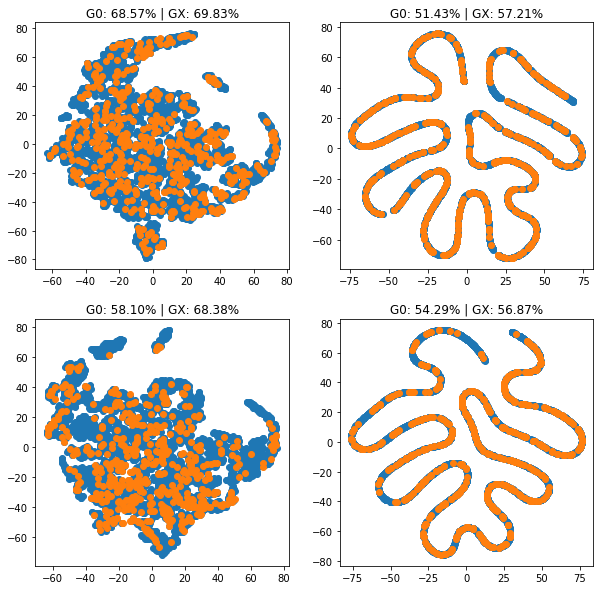

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
a = []

def makeScatter(tsnep, mask, x, y, lab):
  X = tsne_proj[mask,0]
  Y = tsne_proj[mask,1]
  axs[x][y].scatter(X, Y, label = lab ,alpha=1)

for i, task in enumerate(tasks):
  # Base
  base_pred, base_acc_g0, base_acc_gX = get_emb(adj, task)
  tsne_proj = tsne.fit_transform(base_pred.detach())
  makeScatter(tsne_proj, gX, 0, i, 'gX')
  makeScatter(tsne_proj, g0, 0, i, 'g0')
  axs[0][i].title.set_text(f'G0: {base_acc_g0:.2%} | GX: {base_acc_gX:.2%}')


  lock_pred, lock_acc_g0, lock_acc_gX = get_emb(locked_adj, task)
  tsne_proj = tsne.fit_transform(lock_pred.detach())
  makeScatter(tsne_proj, gX, 1, i, 'gX')
  makeScatter(tsne_proj, g0, 1, i, 'g0')
  axs[1][i].title.set_text(f'G0: {lock_acc_g0:.2%} | GX: {lock_acc_gX:.2%}')

  a.append([
    (lock_acc_g0 - base_acc_g0) / base_acc_g0,
    (lock_acc_gX - base_acc_gX) / base_acc_gX,
  ])

plt.show()

NameError: name 'a' is not defined

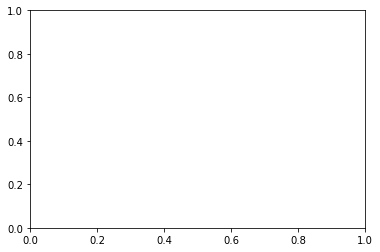

In [ ]:
fig, ax = plt.subplots()
ax.matshow(a, vmin=-1, vmax=1, cmap='bwr')
ax.set_xticklabels([''] + ['Delta G0', 'Delta GX'])
ax.set_yticklabels([''] + ['TASK 0', 'TASK 1'])
# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f'{a[i][j]:.2%}',
                       ha="center", va="center", color="black")